In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import datetime
import fitter

In [12]:
dfx=pd.read_excel((r"C:\Users\HP\OneDrive\Third Year Project\Third Year Project\Data Recodings 8.12.2017- 27.02.2020\Code\completeds_cleaned.xlsx"),header=0,index_col=0)

In [13]:
df=dfx

In [14]:
dfx.head()

,TimeOMS,ValueOMS,ValueOOS,ValueRT,ValueST,ValueOAT,ValueOAH
0,2017-12-08 15:30:52,2,1,24.0,24.0,15.3,62.180
1,2017-12-08 15:40:52,2,1,24.0,24.0,15.1,62.180
2,2017-12-08 15:50:52,2,1,24.5,24.0,15.1,62.895
3,2017-12-08 16:00:52,2,1,24.5,26.0,15.1,62.895
4,2017-12-08 16:10:52,2,1,24.5,26.0,15.6,62.895


In [5]:
#df['ValueOAT']=
df['ValueOAT']=df['ValueOAT'].apply(lambda x: x[1:-1]).astype(float)
len(df)

105998

In [15]:
df['ValueOOS'].value_counts()

0    83325
1    22673
Name: ValueOOS, dtype: int64

In [16]:
##function for anomaly detection ***contextual*** 
def check_anomaly(RT,T1,SO,TH):
    deviationST=TH
    deviationOAT=TH
    if SO==1:#set point temp
        if abs(RT-T1)>=deviationST:
            return 1
        else:
            return 0 
    elif SO==0: #outside temp
        if abs(RT-T1)<=deviationOAT:
            return 1
        else:
            return 0

In [17]:
#applying functions and extracting features 
df['AnomalousST']= df.apply(lambda x: check_anomaly(x.ValueRT,x.ValueST,1,1.5),axis=1)
df['STDeviation']=(df.ValueRT-df.ValueST)
df['AnomalousOAT']= df.apply(lambda x: check_anomaly(x.ValueRT,x.ValueOAT,0,1.5),axis=1)
df['OATDeviation']=(df.ValueRT-df.ValueOAT)
df['HourofDay']=df['TimeOMS'].dt.hour
df['Month']=df['TimeOMS'].dt.month
df['Year']=df['TimeOMS'].dt.year
df['DayofWeek']=df['TimeOMS'].dt.dayofweek

In [9]:
df['ValueOOS'].value_counts()

0    83325
1    22673
Name: ValueOOS, dtype: int64

### EDA when HVAC is ON (OOS=1)

In [18]:
df[(df.ValueOOS==1) & (df.STDeviation==0)]
df1= df[(df.ValueOOS==1)]
df1.to_csv('OnStateData.csv')
df1.to_excel('OnStateData.xlsx')

,ValueOMS,ValueOOS,ValueRT,ValueST,ValueOAT,ValueOAH,AnomalousST,STDeviation,AnomalousOAT,OATDeviation,HourofDay,Month,Year,DayofWeek
count,22673.000000,22673.0,22673.000000,22673.000000,22668.000000,22671.000000,22673.000000,22673.000000,22673.000000,22668.000000,22673.000000,22673.000000,22673.000000,22673.000000
mean,1.531646,1.0,25.710757,25.653972,20.871083,59.764478,0.724739,0.056786,0.086843,4.839567,14.358047,6.187359,2018.779209,2.164116
std,0.499097,0.0,1.958130,2.639396,8.817289,9.731383,0.446656,3.748645,0.281612,7.993472,4.288867,3.685394,0.636900,1.585767
min,1.000000,1.0,14.000000,19.000000,2.000000,38.130000,0.000000,-13.500000,0.000000,-9.900000,0.000000,1.000000,2017.000000,0.000000
25%,1.000000,1.0,25.000000,24.000000,13.300000,51.780000,0.000000,-2.000000,0.000000,-3.200000,11.000000,2.000000,2018.000000,1.000000
50%,2.000000,1.0,26.000000,26.000000,18.100000,58.995000,1.000000,-0.500000,0.000000,7.200000,15.000000,7.000000,2019.000000,2.000000
75%,2.000000,1.0,27.000000,28.000000,29.800000,67.185000,1.000000,2.500000,0.000000,11.700000,18.000000,9.000000,2019.000000,3.000000
max,3.000000,1.0,34.000000,28.000000,35.900000,86.815000,1.000000,13.500000,1.000000,21.200000,23.000000,12.000000,2020.000000,6.000000


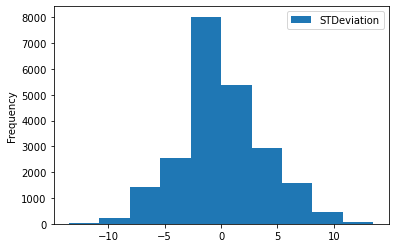

In [19]:
df1.plot(y='STDeviation',kind='hist')
df1.describe()


No handles with labels found to put in legend.


Text(0.5, 1.0, 'Distribution of ST deviation')

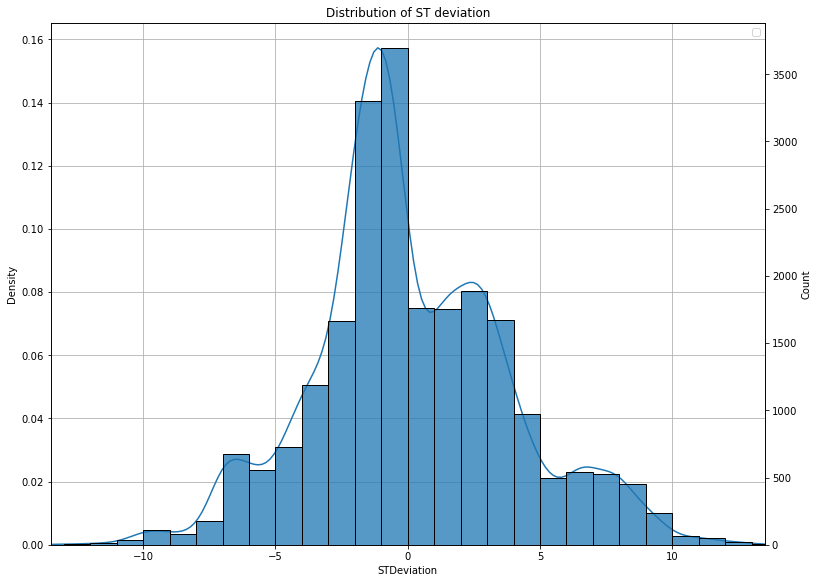

In [20]:
fig= plt.figure(figsize=[12.8,9.6])
ax=fig.add_subplot(111)
sns.kdeplot(data=df1['STDeviation'], ax=ax)
ax.set_xlim((df1['STDeviation'].min(), df1['STDeviation'].max()))
ax2 = ax.twinx()
sns.histplot(data=df1['STDeviation'], discrete=True, ax=ax2)
ax.legend()
ax.grid(True)
plt.title('Distribution of ST deviation')





,sumsquare_error,aic,bic,kl_div
gamma,0.310771,904.411743,-2.538538e+05,inf
norm,0.313426,884.373328,-2.536709e+05,inf
rayleigh,0.631285,inf,-2.377954e+05,inf
poisson,inf,inf,inf,inf


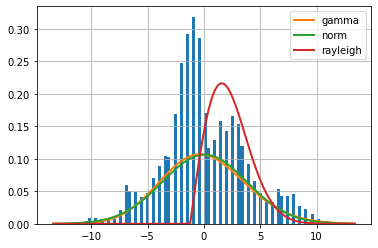

In [21]:
from fitter import Fitter
f = Fitter(df1['STDeviation'],distributions=['gamma',
                          'rayleigh',
                          "poisson",
                          "norm"], timeout= 120)
f.fit()
# may take some time since by default, all distributions are tried
# but you call manually provide a smaller set of distributions
f.summary()

Text(0.5, 1.0, 'Distribution of Outside air temp deviation')

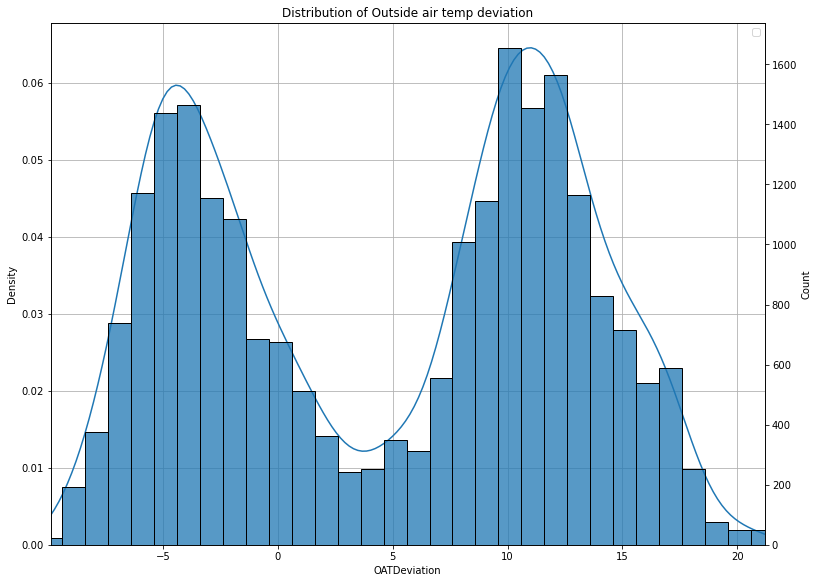

In [22]:
fig= plt.figure(figsize=[12.8,9.6])
ax=fig.add_subplot(111)
sns.kdeplot(data=df1['OATDeviation'], ax=ax)
ax.set_xlim((df1['OATDeviation'].min(), df1['OATDeviation'].max()))
ax2 = ax.twinx()
sns.histplot(data=df1['OATDeviation'], discrete=True, ax=ax2)
ax.legend()
ax.grid(True)
plt.title('Distribution of Outside air temp deviation')


<AxesSubplot:xlabel='TimeOMS', ylabel='ValueOOS'>

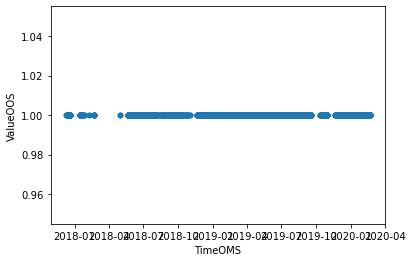

In [23]:
df1.plot(x='TimeOMS',y='ValueOOS',kind='scatter')

<AxesSubplot:>

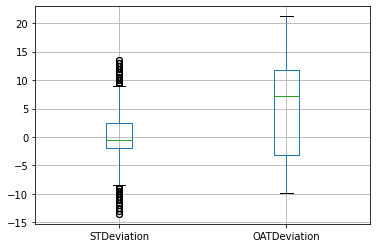

In [24]:
df1.boxplot(column=['STDeviation','OATDeviation'])

<AxesSubplot:>

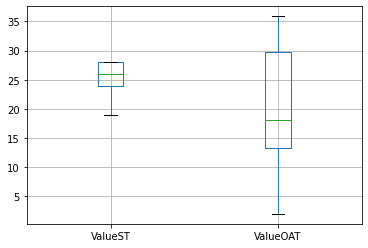

In [25]:
df1.boxplot(column=['ValueST','ValueOAT'])

<AxesSubplot:>

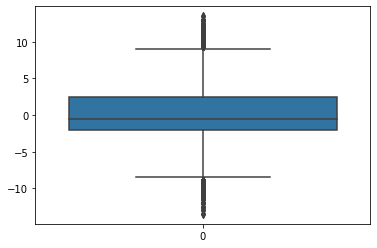

In [26]:
sns.boxplot(data= df1['STDeviation'])

<AxesSubplot:>

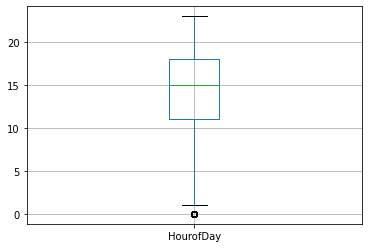

In [27]:
df1.boxplot(column=['HourofDay'])

Text(0.5, 1.0, 'Distribution Active Hours for HVAC')

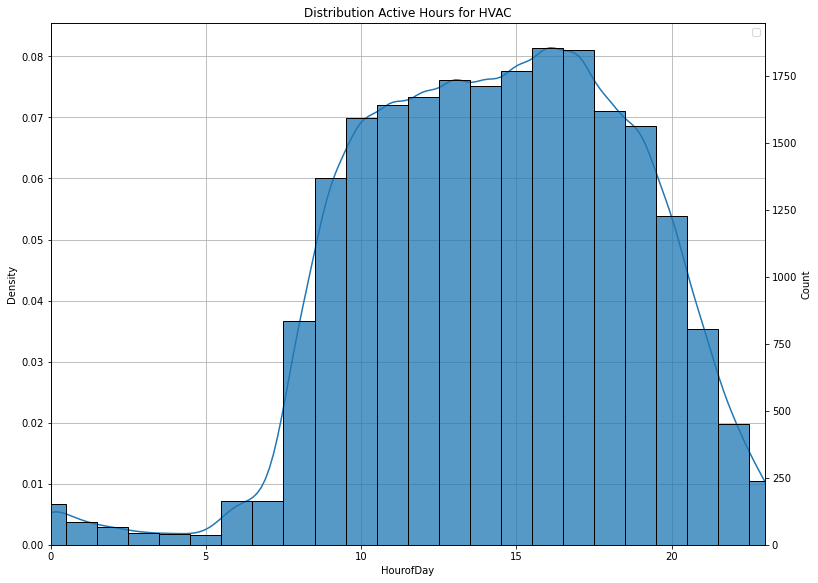

In [28]:
fig= plt.figure(figsize=[12.8,9.6])
ax=fig.add_subplot(111)
sns.kdeplot(data=df1['HourofDay'], ax=ax)
ax.set_xlim((df1['HourofDay'].min(), df1['HourofDay'].max()))
ax2 = ax.twinx()
sns.histplot(data=df1['HourofDay'], discrete=True, ax=ax2)
ax.legend()
ax.grid(True)
plt.title('Distribution Active Hours for HVAC')

In [29]:
df1=df1[(df1.DayofWeek!=5) | (df1.DayofWeek!=6)]
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22673 entries, 0 to 105935
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   TimeOMS       22673 non-null  datetime64[ns]
 1   ValueOMS      22673 non-null  int64         
 2   ValueOOS      22673 non-null  int64         
 3   ValueRT       22673 non-null  float64       
 4   ValueST       22673 non-null  float64       
 5   ValueOAT      22668 non-null  float64       
 6   ValueOAH      22671 non-null  float64       
 7   AnomalousST   22673 non-null  int64         
 8   STDeviation   22673 non-null  float64       
 9   AnomalousOAT  22673 non-null  int64         
 10  OATDeviation  22668 non-null  float64       
 11  HourofDay     22673 non-null  int64         
 12  Month         22673 non-null  int64         
 13  Year          22673 non-null  int64         
 14  DayofWeek     22673 non-null  int64         
dtypes: datetime64[ns](1), float64(6), i

# Transient Response Determinations


In [30]:
scidtest=[]
i=0
for i in range (0,len(df)-1):
    if (df['ValueOOS'][i+1]!=df['ValueOOS'][i]):
        #scidx.append(i)
        scidtest.append(i+1)




In [31]:
#df['ValueOOS'].diff()
df['Consec_id'] = df['ValueOOS'] == df.shift()['ValueOOS']
scidx= df.index[df['Consec_id'] == False].tolist()
df['Change Period']=None
i=0
lsc=[]
df.to_csv('test1')
while i!=len(scidx)-1:
    x=(df.iloc[scidx[i],0]-df.iloc[(scidx[i-1]),0]).total_seconds()
    df.at[scidx[i], 'Change Period']= x
    lsc+=[(scidx[i],scidx[i+1])]
    i+=1
    

In [32]:
def w_avg(grouped):
    d=grouped.iloc[:,0]
    w=grouped.iloc[:,1]
    wm = sum([d[i]*w[i] for i in range(len(grouped))])/sum(w)
    return wm

def wmdn(grouped):
    cumsum=grouped.iloc[:,1].cumsum()
    cutoff=grouped.iloc[:,1].sum()/2.0
    median=grouped.iloc[:,0][cumsum>=cutoff].iloc[0]
    return median

def wavds(df, attribute,columnslist):
    x= pd.DataFrame(columns=columnslist,index=sorted(df[attribute].unique()))
    #x.set_index(df[attribute].unique())
    l1= (df[attribute].unique())
    #print(sorted(l1))
    for col in columnslist:
        for l in (l1):
            x1=df[df[attribute]==l][col].value_counts().reset_index()
            wm1=w_avg(x1)
            wmdn1=wmdn(x1.sort_values(by=col))
            x.at[l,('Median'+col)]=wmdn1
            x.at[l,col]=wm1
            x.at[l,('Mean-Median'+col)]=wmdn1-wm1
    return x

wavds(df1, 'HourofDay', ['ValueRT','ValueST'])

,ValueRT,ValueST,MedianValueRT,Mean-MedianValueRT,MedianValueST,Mean-MedianValueST
0,24.973856,27.27451,27.0,2.026144,28.0,0.725490
1,24.1,27.511765,21.5,-2.600000,28.0,0.488235
2,23.353846,27.938462,26.0,2.646154,28.0,0.061538
3,22.556818,28.0,26.0,3.443182,28.0,0.000000
4,22.345238,28.0,19.0,-3.345238,28.0,0.000000
5,21.567568,27.945946,21.5,-0.067568,28.0,0.054054
6,25.558642,23.685185,31.5,5.941358,19.0,-4.685185
7,23.785276,25.944785,29.5,5.714724,28.0,2.055215
8,23.833333,26.058753,27.5,3.666667,28.0,1.941247
9,24.588386,25.771731,26.0,1.411614,24.0,-1.771731


<AxesSubplot:>

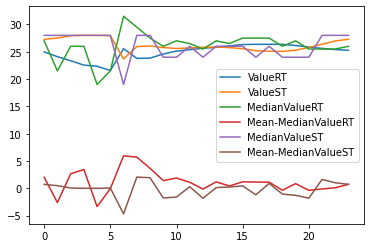

In [25]:
x=wavds(df1, 'HourofDay', ['ValueRT','ValueST'])
x.plot()

In [26]:
x=df1[df1.HourofDay==12]['ValueRT'].value_counts().reset_index()
x.sort_values(by='ValueRT')
def wmdn(grouped):
    cumsum=grouped.iloc[:,1].cumsum()
    cutoff=grouped.iloc[:,1].sum()/2.0
    median=grouped.iloc[:,0][cumsum>=cutoff].iloc[0]
    return median
wmdn(x.sort_values(by='ValueRT'))

25.5

In [33]:
import math
import statsmodels.api as sm
from scipy.stats import t
import sklearn
from statsmodels.regression.rolling import RollingOLS

In [28]:
df_wh= df[(df.HourofDay>8) |(df.HourofDay<18)]

In [34]:
df['b1']=None #beta1
df['b0']=None #beta2
df['t1_ds']=None
df['t1_k']=None
df['sigma']=None
df['xt-u']=None
df['a']=None #constant
#df1.iloc[i,df.columns.get_loc('xt-u')]=b0_val
window=3
feature_col='STDeviation'
df_fin=pd.DataFrame(columns= list(df.columns))
total = sum(range(window+1))
tbar= total/window
t_tbar=0
for x in range(window+1):
    t_tbar+=(x-tbar)
tx= math.sqrt(t_tbar**2)

print([range(0,window)])
l_avgst=[]
for j in range(0,len(lsc)):
    if df.iloc[lsc[j][0],2]==1:
        l_avgst+=[(df['STDeviation'].iloc[lsc[j][0]:lsc[j][1]].mean(axis=0))]
        df1=df.iloc[lsc[j][0]:lsc[j][1]]
        if len(df1)>=(window):
            for i in range(window,len(df1)):
                temp=df1.iloc[i-window:i,:].reset_index()
                temp['index']+=1
                #print(temp)
                RollOLS=sm.OLS(temp.loc[:,feature_col],sm.add_constant(temp.loc[:,['index']])).fit()
                df1.iloc[i,df.columns.get_loc('a')]=RollOLS.params[0]
                df1.iloc[i,df.columns.get_loc('b1')]=RollOLS.params[1]
                b0_val=((temp[feature_col].sum())-(RollOLS.params[1]*total))/window
                #print(b0_val)
                phi=0
                for k in range(0,window):
                    phi1= (temp.loc[k,feature_col]-(RollOLS.params[1]*temp.loc[k,'index'])-b0_val)**2
                    phi+=phi1
                xt=(temp.loc[0,feature_col])




                alpha=math.sqrt(phi/(window-2))
                xtu=(xt-b0_val)/alpha
                std=alpha/tx
                t1_ds=RollOLS.params[1]/std


                df1.iloc[i,df.columns.get_loc('b0')]=b0_val
                df1.iloc[i,df.columns.get_loc('sigma')]=std
                df1.iloc[i,df.columns.get_loc('t1_ds')]=t1_ds
                df1.iloc[i,df.columns.get_loc('t1_k')]=xtu


            #print(df1)

            df_fin=df_fin.append(df1)


            

[range(0, 3)]


D:\Anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [36]:
 df_fin

,TimeOMS,ValueOMS,ValueOOS,ValueRT,ValueST,ValueOAT,ValueOAH,AnomalousST,STDeviation,AnomalousOAT,...,Change Period,b1,b0,t1_ds,t1_k,sigma,xt-u,a,SSt_ds,SSt_k
0,2017-12-08 15:30:52,2,1,24.0,24.0,15.3,62.180,0,0.0,0,...,-69487946.0,None,None,None,None,None,None,None,NaN,NaN
1,2017-12-08 15:40:52,2,1,24.0,24.0,15.1,62.180,0,0.0,0,...,None,None,None,None,None,None,None,None,NaN,NaN
2,2017-12-08 15:50:52,2,1,24.5,24.0,15.1,62.895,0,0.5,0,...,None,None,None,None,None,None,None,None,NaN,NaN
3,2017-12-08 16:00:52,2,1,24.5,26.0,15.1,62.895,1,-1.5,0,...,None,0.25,-0.333333,2.44949,1.632993,0.102062,None,-0.333333,1.0,1.0
4,2017-12-08 16:10:52,2,1,24.5,26.0,15.6,62.895,1,-1.5,0,...,None,-0.75,1.166667,-0.90798,-0.706207,0.826009,None,1.916667,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105931,2020-02-20 20:53:18,2,1,25.5,26.5,13.6,70.370,0,-1.0,0,...,None,-0.25,0.166667,-0.000011,-0.000004,22934.084743,None,26482.166667,1.0,1.0
105932,2020-02-20 21:03:18,2,1,25.5,26.5,13.1,70.370,0,-1.0,0,...,None,-0.25,-0.166667,-0.000011,-0.000007,22934.30125,None,26482.083333,1.0,1.0
105933,2020-02-20 21:13:18,2,1,25.5,26.5,13.1,69.330,0,-1.0,0,...,None,-0.25,-0.333333,-0.000011,-0.000004,22934.517756,None,26482.166667,1.0,1.0
105934,2020-02-20 21:23:18,2,1,25.0,26.5,13.1,70.370,1,-1.5,0,...,None,0.0,-1.0,0.000011,0.000022,0.0,None,-1.0,1.0,1.0


In [35]:
a=0.05
p1= 1-(a/2) 
p2=1-a
degree = window-2
# retrieve value <= probability
value1 = t.ppf(p1, degree)
value2 = t.ppf(p2, degree)
print(value1)
print(value2)
# confirm with cdf
p1 = t.cdf(value1, degree)
p2 = t.cdf(value2, degree)
print(p1)
print(p2)

def t_test(t1,t_val):
    if t1!=None:
        if abs(t1)<t_val:
            return 1
        
df_fin['SSt_ds']= df_fin['t1_ds'].apply(t_test,t_val=value1)
df_fin['SSt_k']= df_fin['t1_k'].apply(t_test,t_val=value2)

#df_fin['SSt']=df_fin['SSt'].fillna(0)

12.706204736432095
6.313751514800932
0.9750000000005044
0.9500000000009806


In [37]:
print(df_fin[df_fin['SSt_k']==1].describe())



            ValueRT       ValueST      ValueOAT      ValueOAH   STDeviation  \
count  16958.000000  16958.000000  16955.000000  16957.000000  16958.000000   
mean      25.689851     25.694274     20.698850     59.832763     -0.004423   
std        1.800710      2.653794      8.919982      9.802376      3.608385   
min       15.000000     19.000000      2.500000     38.130000    -12.000000   
25%       25.000000     24.000000     13.100000     51.780000     -2.000000   
50%       26.000000     26.000000     17.600000     59.125000     -0.500000   
75%       27.000000     28.000000     29.900000     67.315000      2.500000   
max       32.000000     28.000000     35.900000     86.555000     12.500000   

       OATDeviation   SSt_ds    SSt_k  
count  16955.000000  16958.0  16958.0  
mean       4.990947      1.0      1.0  
std        8.172984      0.0      0.0  
min       -9.900000      1.0      1.0  
25%       -3.500000      1.0      1.0  
50%        7.800000      1.0      1.0  
75%     

In [38]:
print(df_fin[df_fin['SSt_ds']==1].describe())

            ValueRT       ValueST      ValueOAT      ValueOAH   STDeviation  \
count  16958.000000  16958.000000  16955.000000  16957.000000  16958.000000   
mean      25.689851     25.694274     20.698850     59.832763     -0.004423   
std        1.800710      2.653794      8.919982      9.802376      3.608385   
min       15.000000     19.000000      2.500000     38.130000    -12.000000   
25%       25.000000     24.000000     13.100000     51.780000     -2.000000   
50%       26.000000     26.000000     17.600000     59.125000     -0.500000   
75%       27.000000     28.000000     29.900000     67.315000      2.500000   
max       32.000000     28.000000     35.900000     86.555000     12.500000   

       OATDeviation   SSt_ds    SSt_k  
count  16955.000000  16958.0  16958.0  
mean       4.990947      1.0      1.0  
std        8.172984      0.0      0.0  
min       -9.900000      1.0      1.0  
25%       -3.500000      1.0      1.0  
50%        7.800000      1.0      1.0  
75%     

## Creating Training Set 

In [44]:
dataset= df_fin[df_fin['SSt_k']==1]

In [45]:
dataset['SSt_k'].value_counts() 

1.0    16958
Name: SSt_k, dtype: int64

In [46]:
dataset.columns

Index(['TimeOMS', 'ValueOMS', 'ValueOOS', 'ValueRT', 'ValueST', 'ValueOAT',
       'ValueOAH', 'AnomalousST', 'STDeviation', 'AnomalousOAT',
       'OATDeviation', 'HourofDay', 'Month', 'Year', 'DayofWeek', 'Consec_id',
       'Change Period', 'b1', 'b0', 't1_ds', 't1_k', 'sigma', 'xt-u', 'a',
       'SSt_ds', 'SSt_k'],
      dtype='object')

In [48]:
dataset=dataset[['TimeOMS', 'ValueOMS', 'ValueOOS', 'ValueRT', 'ValueST', 'ValueOAT',
       'AnomalousST', 'STDeviation', 'AnomalousOAT', 'OATDeviation','ValueOAH',
       'HourofDay', 'Month', 'Year', 'DayofWeek']]

In [49]:
dataset.describe()

,ValueRT,ValueST,ValueOAT,STDeviation,OATDeviation,ValueOAH
count,16958.000000,16958.000000,16955.000000,16958.000000,16955.000000,16957.000000
mean,25.689851,25.694274,20.698850,-0.004423,4.990947,59.832763
std,1.800710,2.653794,8.919982,3.608385,8.172984,9.802376
min,15.000000,19.000000,2.500000,-12.000000,-9.900000,38.130000
25%,25.000000,24.000000,13.100000,-2.000000,-3.500000,51.780000
50%,26.000000,26.000000,17.600000,-0.500000,7.800000,59.125000
75%,27.000000,28.000000,29.900000,2.500000,11.900000,67.315000
max,32.000000,28.000000,35.900000,12.500000,21.200000,86.555000


In [50]:
dataset.head()

,TimeOMS,ValueOMS,ValueOOS,ValueRT,ValueST,ValueOAT,AnomalousST,STDeviation,AnomalousOAT,OATDeviation,ValueOAH,HourofDay,Month,Year,DayofWeek
3,2017-12-08 16:00:52,2,1,24.5,26.0,15.1,1,-1.5,0,9.4,62.895,16,12,2017,4
4,2017-12-08 16:10:52,2,1,24.5,26.0,15.6,1,-1.5,0,8.9,62.895,16,12,2017,4
403,2017-12-11 10:40:52,2,1,20.0,25.0,14.6,1,-5.0,0,5.4,55.420,10,12,2017,0
404,2017-12-11 10:50:52,2,1,20.5,25.0,14.6,1,-4.5,0,5.9,56.460,10,12,2017,0
405,2017-12-11 11:00:52,2,1,21.0,25.0,14.6,1,-4.0,0,6.4,56.460,11,12,2017,0


In [51]:
dataset['AnomalousST'].value_counts()

1    12354
0     4604
Name: AnomalousST, dtype: int64

In [48]:
df_ST= dataset[dataset['AnomalousST']==1]
df_ST.describe()


,ValueRT,ValueST,ValueOAT,STDeviation,OATDeviation,Season
count,12354.00000,12354.000000,12351.000000,12354.000000,12351.000000,12354.000000
mean,25.48883,25.387810,20.947462,0.101020,4.541244,2.808888
std,1.98214,2.950158,9.596608,4.201209,8.513523,1.103331
min,15.00000,19.000000,2.500000,-12.000000,-9.900000,1.000000
25%,24.50000,24.000000,12.200000,-3.000000,-4.000000,2.000000
50%,26.00000,26.000000,17.400000,-1.500000,7.200000,3.000000
75%,26.50000,28.000000,30.600000,3.000000,12.100000,4.000000
max,32.00000,28.000000,35.900000,12.500000,21.200000,4.000000


In [41]:
dataset['AnomalousOAT'].value_counts()

0    15731
1     1227
Name: AnomalousOAT, dtype: int64

In [42]:
dataset['ValueOMS'].value_counts()

2    9328
1    7630
Name: ValueOMS, dtype: int64

In [52]:
dataset['Season']=0
#season classification
def season_classification(x): 
    if ((x==3) or x==4 or (x==5)): 
        return 1
    if ((x==6) or x==7 or (x==8)): 
        return 2
    if ((x==9) or (x==10) or (x==11)): 
        return 3
    if ((x==12) or (x==1) or (x==2)): 
        return 4
dataset['Season']=dataset.apply(lambda x: season_classification(x['Month']), axis=1)

<ipython-input-52-ea220e6b312d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Season']=0
<ipython-input-52-ea220e6b312d>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Season']=dataset.apply(lambda x: season_classification(x['Month']), axis=1)


In [53]:
dataset['Season'].value_counts()

4    7090
2    5468
1    2438
3    1962
Name: Season, dtype: int64

In [54]:
dataset[['ValueOMS', 'ValueOOS','AnomalousST', 'AnomalousOAT', 'HourofDay', 'Month', 'Year', 'DayofWeek']]=dataset[['ValueOMS', 'ValueOOS','AnomalousST', 'AnomalousOAT', 'HourofDay', 'Month', 'Year', 'DayofWeek']].astype(float)

D:\Anaconda3\lib\site-packages\pandas\core\frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [55]:
dataset.dtypes

TimeOMS         datetime64[ns]
ValueOMS               float64
ValueOOS               float64
ValueRT                float64
ValueST                float64
ValueOAT               float64
AnomalousST            float64
STDeviation            float64
AnomalousOAT           float64
OATDeviation           float64
ValueOAH               float64
HourofDay              float64
Month                  float64
Year                   float64
DayofWeek              float64
Season                   int64
dtype: object

In [56]:
dataset.to_csv('final_ds.csv', index=False)